In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from fashion_model import FashionCNN 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def arg_parse():
    parser = argparse.ArgumentParser(description="UMAP discriminator")
    parser.add_argument(
            "--exp", dest="exp", help="Experiments"
        )
    parser.add_argument(
            "--std", dest="std", type=float, help="Perturbation std"
        )
    parser.add_argument(
        "--multiplier", dest="multiplier", type=int, help="Number of times an image is perturbed"
    )
    parser.add_argument(
        "--perturbations", dest="num_perturbations", type=int, help="Number of perturbations"
    )
    parser.add_argument(
        "--dim", dest="dim", type=int, help="Number of low dim"
    )
    parser.add_argument(
        "--pivots", dest="pivots", type=int, help="Number of pivots"
    )
    parser.add_argument(
        "--shuffle", dest="shuffle", type=bool, help="Shuffle the pivots"
    )
    parser.add_argument(
            "--train_ratio", dest="train_ratio", type=float, help="ratio of training for the rf"
        )
    
        
    parser.set_defaults(
        exp = 'fashion_mnist',
        std = 0.1,
        num_perturbations = 100,
#         runs = 10,
        multiplier = 100,
        dim = 2,
        pivots = 10,
        shuffle = True,
        train_ratio = 0.5
    )
    return parser.parse_args()

# prog_args = arg_parse()


EXPERIMENT = 'mnist'
PERTURBATION_STD = 0.1
NUM_PERTURBATIONS = 100
MULTIPLIER = 100
DIM = 3
PIVOTS = 10
SHUFFLE = False
TRAIN_RATIO = 0.5

print("EXPERIMENT: ", EXPERIMENT)
print("MULTIPLIER: ", MULTIPLIER)
print("PERTURBATION_STD: ", PERTURBATION_STD)
print("DIM: ", DIM)
print("PIVOTS: ", PIVOTS)
print("SHUFFLE: ", SHUFFLE)

EXPERIMENT:  mnist
MULTIPLIER:  100
PERTURBATION_STD:  0.1
DIM:  3
PIVOTS:  10
SHUFFLE:  False


In [2]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))


Loading mnist
Done loading


In [3]:
import numpy as np
import torch
import random
from sklearn import linear_model
import umap

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

class Manifold_Image_Sampler(object):
    # Expect torch data
    def __init__(self, data, dim = 2, random_state = 1,
                labels = None,
                std_train = 0.2):
        """Init function.

        Args:
            data: traning data
        """
        self.data = data
        self.dim = dim
        self.std_train = std_train
        self.no_training, self.channels, self.rows, self.cols = self.data.shape
        self.data_min = torch.min(self.data)
        self.data_max = torch.max(self.data)
        data_1d = data.reshape((self.no_training, self.channels*self.rows*self.cols))
        self.mapper = umap.UMAP(n_components = self.dim, random_state = random_state)
        self.mapper.fit(data_1d)
        self.labels = labels
        self.pivots = None
        self.planes = None
        
    def get_pivots(self, labels, no_pivots_per_label = 1, shuffle = False, target_labels = None):        
        if target_labels == None:
            target_labels = torch.unique(labels)
        
        buff = []
        for l in target_labels:
            all_idx = (labels == l).nonzero(as_tuple=False)

            if shuffle == False:
                idx = all_idx[range(no_pivots_per_label)]
            else:
                idx = all_idx[random.sample(range(len(all_idx)),no_pivots_per_label )]
            
            for i in idx:
                buff.append(i)
        buff = [buff[i].cpu().detach().numpy()[0] for i in range(len(buff))]
            
        self.pivots = self.data[buff].clone()
        return buff
    
    def transform(self, x_data):
#         Expect [N,c,l,w] data 
        no_data, channels, rows, cols = x_data.shape
        return self.mapper.transform(x_data.reshape(no_data, channels*rows*cols))

    def inv_transform(self, low_data):
#         Expect [N,d] data
        no_data, low_dim = low_data.shape

        assert low_dim == self.dim, "Mismatched dimension"

        inv_1d_imgs = self.mapper.inverse_transform(low_data)
        inv_imgs = inv_1d_imgs.reshape((no_data, self.channels, self.rows, self.cols))

        return inv_imgs
    
    def get_G_from_samples(self, x_sample):
        matA = self.mapper.transform(self.to_1d(x_sample.cpu().detach().numpy()))
        matB = self.to_1d(x_sample.cpu().detach().numpy())
        Xt = np.transpose(matA)
        XtX = np.dot(Xt,matA)
        Xty = np.dot(Xt,matB)
        matG = np.linalg.solve(XtX,Xty)
        return matG
    
    def get_G_from_pivots(self):
        matA = self.mapper.transform(self.to_1d(self.pivots.cpu().detach().numpy()))
        matB = self.to_1d(self.pivots.cpu().detach().numpy())
        Xt = np.transpose(matA)
        XtX = np.dot(Xt,matA)
        Xty = np.dot(Xt,matB)
        matG = np.linalg.solve(XtX,Xty)
        return matG
    
    def to_1d(self, data):
        return data.reshape((data.shape[0], self.channels*self.rows*self.cols))

    def to_3d(self, data):
        return data.reshape((data.shape[0], self.channels, self.rows, self.cols))


In [4]:
RUNS = 10
TARGET = 2

In [5]:
start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

if TARGET == None:
    targets = np.array(torch.unique(all_labels))
    target_str = 'all'
else:
    targets = [TARGET]
    target_str = str(TARGET)

# Get the hyperplanes
_ = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=targets)
manifold_G = manifold_sampler.get_G_from_pivots()
Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

Initialize duration:  239.0878767967224


In [6]:
def norm_compute(v):
    return np.sqrt(np.sum(v**2))

def get_discriminator(X,y,n_estimators = 100):
    the_rf = RandomForestClassifier(n_estimators=n_estimators).fit(X, y)
    y_pred = the_rf.predict(X)
    the_rf_result = (y_pred == y).sum()
    return the_rf, the_rf_result/y.shape[0]

def get_discriminator_performance(X,y,rf):
    y_pred = rf.predict(X)
    the_rf_result = (y_pred == y).sum()
    return the_rf_result/y.shape[0]

In [7]:
factor = 0.01
RADIUS = 2 * factor
base_RADIUS = 1 * factor 

In [8]:
# start_time = time.time()
base_gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
r = np.random.uniform()*base_RADIUS
base_gauss_norm = normalize(base_gauss_, r)
base_pc = manifold_sampler.to_1d(manifold_sampler.pivots + base_gauss_norm) 

gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
gauss_noise = manifold_sampler.to_1d(gauss_)
plane_noise = np.zeros_like(gauss_noise)
for d in range(Gv.shape[0]):
    proj = np.dot(gauss_noise, Gv[d])
    for s in range(plane_noise.shape[0]):
        plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
ortho_noise = gauss_noise - plane_noise

# noise
r = np.random.uniform()*RADIUS
ortho_norm = normalize(ortho_noise, r)
plane_norm = normalize(plane_noise, r)
gauss_norm = normalize(gauss_noise, r)

# point clouds
ortho_pc = base_pc + ortho_norm
plane_pc = base_pc + plane_norm
gauss_pc = base_pc + gauss_norm
# ortho_pc = manifold_sampler.to_1d(manifold_sampler.pivots) + ortho_norm
# plane_pc = manifold_sampler.to_1d(manifold_sampler.pivots) + plane_norm
# gauss_pc = manifold_sampler.to_1d(manifold_sampler.pivots) + gauss_norm

ori_pc = manifold_sampler.to_1d(manifold_sampler.pivots).cpu().detach().numpy()
base_pc = base_pc.cpu().detach().numpy()
ortho_pc = ortho_pc.cpu().detach().numpy()
plane_pc = plane_pc.cpu().detach().numpy()
gauss_pc = gauss_pc.cpu().detach().numpy()

# base_pc = ori_pc

X_discriminator_gauss = np.vstack((base_pc[::2], gauss_pc[::2]))
X_discriminator_plane = np.vstack((base_pc[::2], plane_pc[::2]))
X_discriminator_ortho = np.vstack((base_pc[::2], ortho_pc[::2]))
y_discriminator = np.concatenate((np.zeros(ori_pc[::2].shape[0]), np.ones(ori_pc[::2].shape[0])))

the_rf_gauss, train_acc_gauss = get_discriminator(X_discriminator_gauss, y_discriminator, n_estimators = 100)
the_rf_plane, train_acc_plane = get_discriminator(X_discriminator_plane, y_discriminator, n_estimators = 100)
the_rf_ortho, train_acc_ortho = get_discriminator(X_discriminator_ortho, y_discriminator, n_estimators = 100)

print("Gauss:")
# print(train_acc_gauss)
print(get_discriminator_performance(gauss_pc[1::2], np.ones(gauss_pc[1::2].shape[0]) , the_rf_gauss))
# print(get_discriminator_performance(base_pc, np.zeros(base_pc.shape[0]) , the_rf_gauss))

print("Plane:")
# print(train_acc_plane)
print(get_discriminator_performance(plane_pc[1::2], np.ones(plane_pc[1::2].shape[0]) , the_rf_plane))
# print(get_discriminator_performance(base_pc, np.zeros(base_pc.shape[0]) , the_rf_plane))

print("Ortho:")
# print(train_acc_ortho)
print(get_discriminator_performance(ortho_pc[1::2], np.ones(ortho_pc[1::2].shape[0]) , the_rf_ortho))
# print(get_discriminator_performance(base_pc, np.zeros(base_pc.shape[0]) , the_rf_ortho))

Gauss:
1.0
Plane:
1.0
Ortho:
1.0


In [9]:
p_LIME = 0.8

lime_mask = np.random.uniform(0, 1, size=ori_pc.shape)
lime_mask[lime_mask > p_LIME] = 1
lime_mask[lime_mask <= p_LIME] = 0
    
data_max = manifold_sampler.data_max.cpu().item()
data_min = manifold_sampler.data_min.cpu().item()
noise_uniform = np.random.uniform(data_min, data_max, size=ori_pc.shape)
lime_noise_mask = noise_uniform * lime_mask

In [10]:
SHAP_bg = ori_pc.mean(axis = 0)
SHAP_bg = np.tile(SHAP_bg,(ori_pc.shape[0],1))
shap_noise_mask = SHAP_bg * lime_mask

In [11]:
lime_pc = base_pc.copy()
lime_pc[lime_noise_mask != 0] = lime_noise_mask[lime_noise_mask != 0]
shap_pc = base_pc.copy()
shap_pc[shap_noise_mask != 0] = shap_noise_mask[shap_noise_mask != 0]

X_discriminator_lime = np.vstack((base_pc[::2], lime_pc[::2]))
X_discriminator_shap = np.vstack((base_pc[::2], shap_pc[::2]))

In [12]:
tp_shap = []
tn_shap = []
tp_lime = []
tn_lime = []

ALPHA = 0

the_rf_lime, train_acc_lime = get_discriminator(X_discriminator_lime, y_discriminator, n_estimators = 100)
tp_lime.append(get_discriminator_performance(lime_pc[1::2] - ALPHA*(lime_pc[1::2]-base_pc[1::2]), np.ones(lime_pc[1::2].shape[0]) , the_rf_lime))
tn_lime.append(get_discriminator_performance(base_pc[1::2], np.zeros(base_pc[1::2].shape[0]) , the_rf_lime))

the_rf_shap, train_acc_shap = get_discriminator(X_discriminator_shap, y_discriminator, n_estimators = 100)
tp_shap.append(get_discriminator_performance(shap_pc[1::2] - ALPHA*(shap_pc[1::2]-base_pc[1::2]), np.ones(shap_pc[1::2].shape[0]) , the_rf_shap))
tn_shap.append(get_discriminator_performance(base_pc[1::2], np.zeros(base_pc[1::2].shape[0]) , the_rf_shap))

In [13]:
tp_lime

[1.0]

In [ ]:
# LIME SHAP
# p_LIME = 0.8

# lime_mask = np.random.uniform(0, 1, size=ori_pc.shape)
# lime_mask[lime_mask > p_LIME] = 1
# lime_mask[lime_mask <= p_LIME] = 0
    
# data_max = manifold_sampler.data_max.cpu().item()
# data_min = manifold_sampler.data_min.cpu().item()
# noise_uniform = np.random.uniform(data_min, data_max, size=ori_pc.shape)
# lime_noise_mask = noise_uniform * lime_mask
    
    SHAP_bg = ori_pc.mean(axis = 0)
    SHAP_bg = np.tile(SHAP_bg,(ori_pc.shape[0],1))
    shap_noise_mask = SHAP_bg * lime_mask
    
    lime_pc = base_pc.copy()
    lime_pc[lime_noise_mask != 0] = lime_noise_mask[lime_noise_mask != 0]
    shap_pc = base_pc.copy()
    shap_pc[shap_noise_mask != 0] = shap_noise_mask[shap_noise_mask != 0]
    
    X_discriminator_lime = np.vstack((base_pc[::2], lime_pc[::2]))
    X_discriminator_shap = np.vstack((base_pc[::2], shap_pc[::2]))

    the_rf_lime, train_acc_lime = get_discriminator(X_discriminator_lime, y_discriminator, n_estimators = 100)
    tp_lime.append(get_discriminator_performance(lime_pc[1::2] - ALPHA*(lime_pc[1::2]-base_pc[1::2]), np.ones(lime_pc[1::2].shape[0]) , the_rf_lime))
    tn_lime.append(get_discriminator_performance(base_pc[1::2], np.zeros(base_pc[1::2].shape[0]) , the_rf_lime))

    the_rf_shap, train_acc_shap = get_discriminator(X_discriminator_shap, y_discriminator, n_estimators = 100)
    tp_shap.append(get_discriminator_performance(shap_pc[1::2] - ALPHA*(shap_pc[1::2]-base_pc[1::2]), np.ones(shap_pc[1::2].shape[0]) , the_rf_shap))
    tn_shap.append(get_discriminator_performance(base_pc[1::2], np.zeros(base_pc[1::2].shape[0]) , the_rf_shap))

In [182]:
# print(norm_compute(base_pc-ortho_pc))
# print(norm_compute(base_pc-plane_pc))
# print(norm_compute(base_pc-gauss_pc))

In [198]:
# # base_pc = ori_pc

# X_discriminator_gauss = np.vstack((base_pc[::2], gauss_pc[::2]))
# X_discriminator_plane = np.vstack((base_pc[::2], plane_pc[::2]))
# X_discriminator_ortho = np.vstack((base_pc[::2], ortho_pc[::2]))
# y_discriminator = np.concatenate((np.zeros(ori_pc[::2].shape[0]), np.ones(ori_pc[::2].shape[0])))

# the_rf_gauss, train_acc_gauss = get_discriminator(X_discriminator_gauss, y_discriminator, n_estimators = 100)
# the_rf_plane, train_acc_plane = get_discriminator(X_discriminator_plane, y_discriminator, n_estimators = 100)
# the_rf_ortho, train_acc_ortho = get_discriminator(X_discriminator_ortho, y_discriminator, n_estimators = 100)

# print("Gauss:")
# # print(train_acc_gauss)
# print(get_discriminator_performance(gauss_pc[1::2], np.ones(gauss_pc[1::2].shape[0]) , the_rf_gauss))
# print(get_discriminator_performance(base_pc, np.zeros(base_pc.shape[0]) , the_rf_gauss))

# print("Plane:")
# # print(train_acc_plane)
# print(get_discriminator_performance(plane_pc[1::2], np.ones(plane_pc[1::2].shape[0]) , the_rf_plane))
# print(get_discriminator_performance(base_pc, np.zeros(base_pc.shape[0]) , the_rf_plane))

# print("Ortho:")
# # print(train_acc_ortho)
# print(get_discriminator_performance(ortho_pc[1::2], np.ones(ortho_pc[1::2].shape[0]) , the_rf_ortho))
# print(get_discriminator_performance(base_pc, np.zeros(base_pc.shape[0]) , the_rf_ortho))

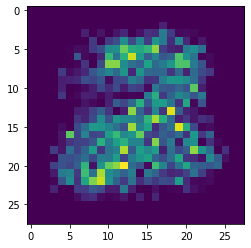

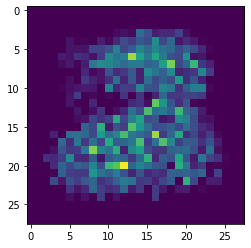

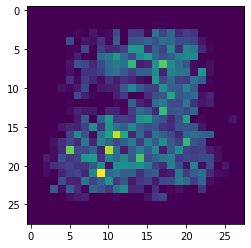

In [9]:
rf_imp = the_rf_gauss.feature_importances_
rf_imp_3d = rf_imp.reshape((28,28))
plt.figure()
plt.imshow(rf_imp_3d)

rf_imp = the_rf_plane.feature_importances_
rf_imp_3d = rf_imp.reshape((28,28))
plt.figure()
plt.imshow(rf_imp_3d)

rf_imp = the_rf_ortho.feature_importances_
rf_imp_3d = rf_imp.reshape((28,28))
plt.figure()
plt.imshow(rf_imp_3d)